# Example of Calibration

Import stuff

In [2]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt

from dask.distributed import Client
from dask_jobqueue import SLURMCluster

import nevergrad as ng
from mhpc_project.matsch_b2 import CalibrationModel, Variables, Loss, NGO
from geotopy.utils import date_parser, comparison_plot, ProgressBar, ParameterLogger
from geotopy.measures import KGE

Launch Dask cluster using `dask-jobqueue`

In [4]:
cluster = SLURMCluster()
cluster.adapt(maximum_jobs=256)

client = Client(cluster)

Load observations, model, loss function and calibration strategy

In [5]:
observations = pd.read_csv('../data/Matsch B2/obs.csv',
                           na_values=['-9999', '-99.99'],
                           usecols=[0, 7],
                           parse_dates=[0],
                           date_parser=date_parser,
                           index_col=0,
                           squeeze=True)
observations.index.rename('datetime', inplace=True)
model = CalibrationModel('../data/Matsch B2/geotop', run_args={'timeout': 120})
variables = Variables('../data/Matsch B2/variables.csv')
measure = KGE(observations)
loss = Loss(model, variables, measure)
calibration = NGO(loss, budget=4096, num_workers=512)

Evaluate the model and plot the risults

Before optimization loss is -0.2476496401298781


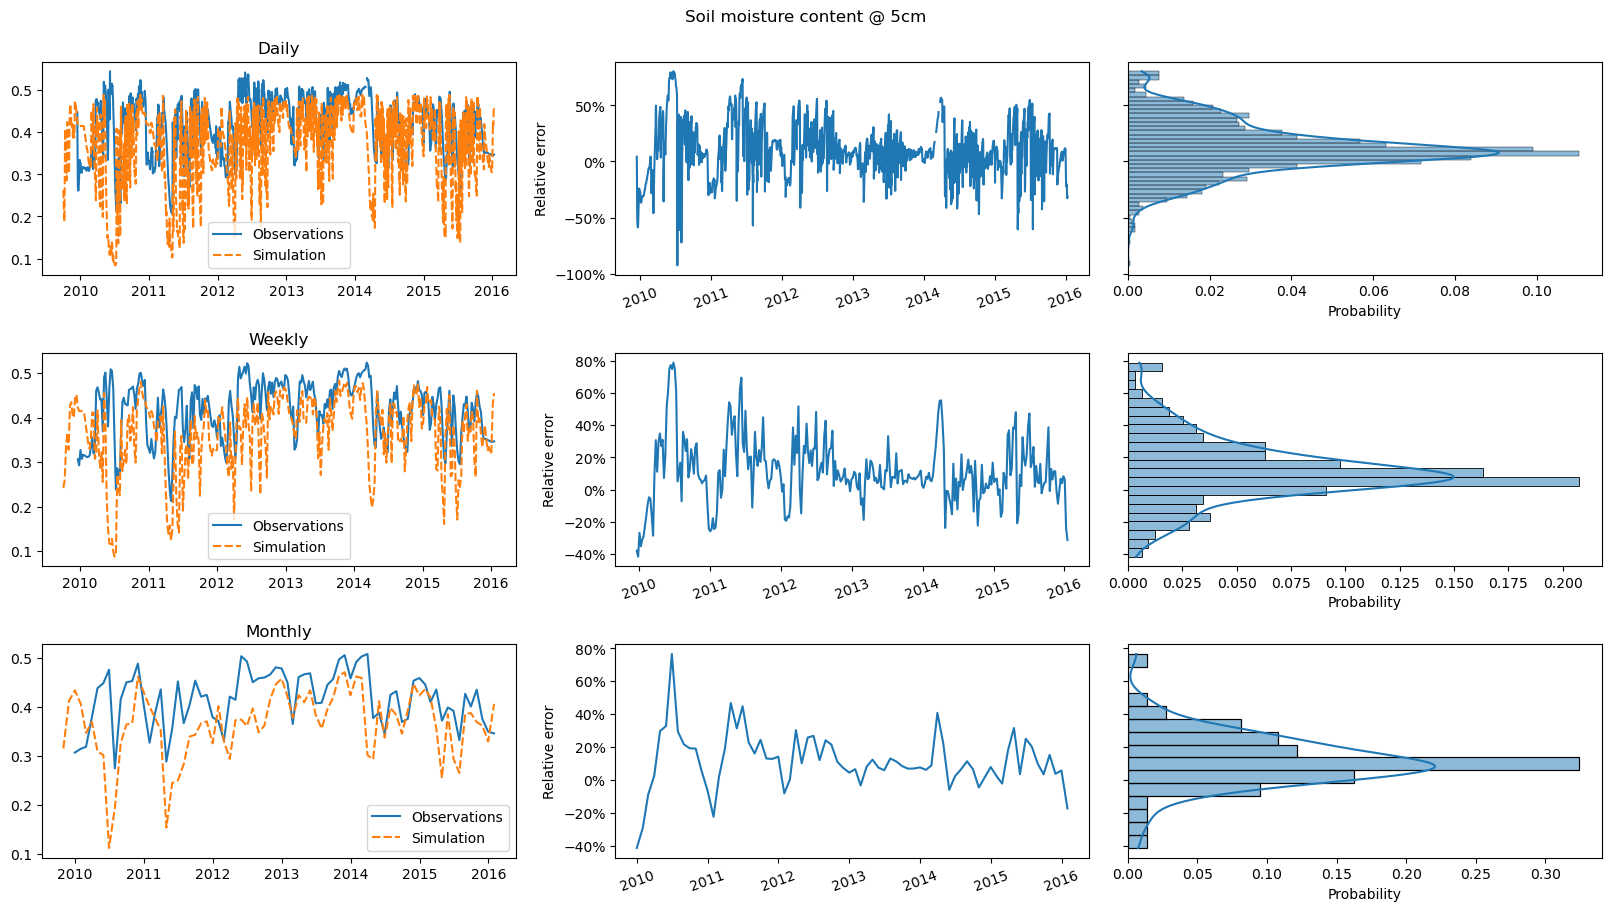

In [6]:
simulation = model()
print(f"Before optimization loss is {measure(simulation)}")
comparison_plot(observations,
                simulation,
                desc='Soil moisture content @ 5cm',
                rel=True)
plt.show()

Run calibration

In [7]:
logger = ParameterLogger(loss.massage)

calibration.optimizer.register_callback('tell', logger)

calibration.optimizer.register_callback('tell', ProgressBar(total=calibration.optimizer.budget))

with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")
    recommendation, best_loss = calibration(executor=client)

(256_w,512)-aCMA-ES (mu_w=131.7,w_1=2%) in dimension 21 (seed=<module 'time' (built-in)>, Fri Nov 20 19:27:39 2020)


Plot results and show table of calibrated values

After optimization loss is -0.5021433797788915


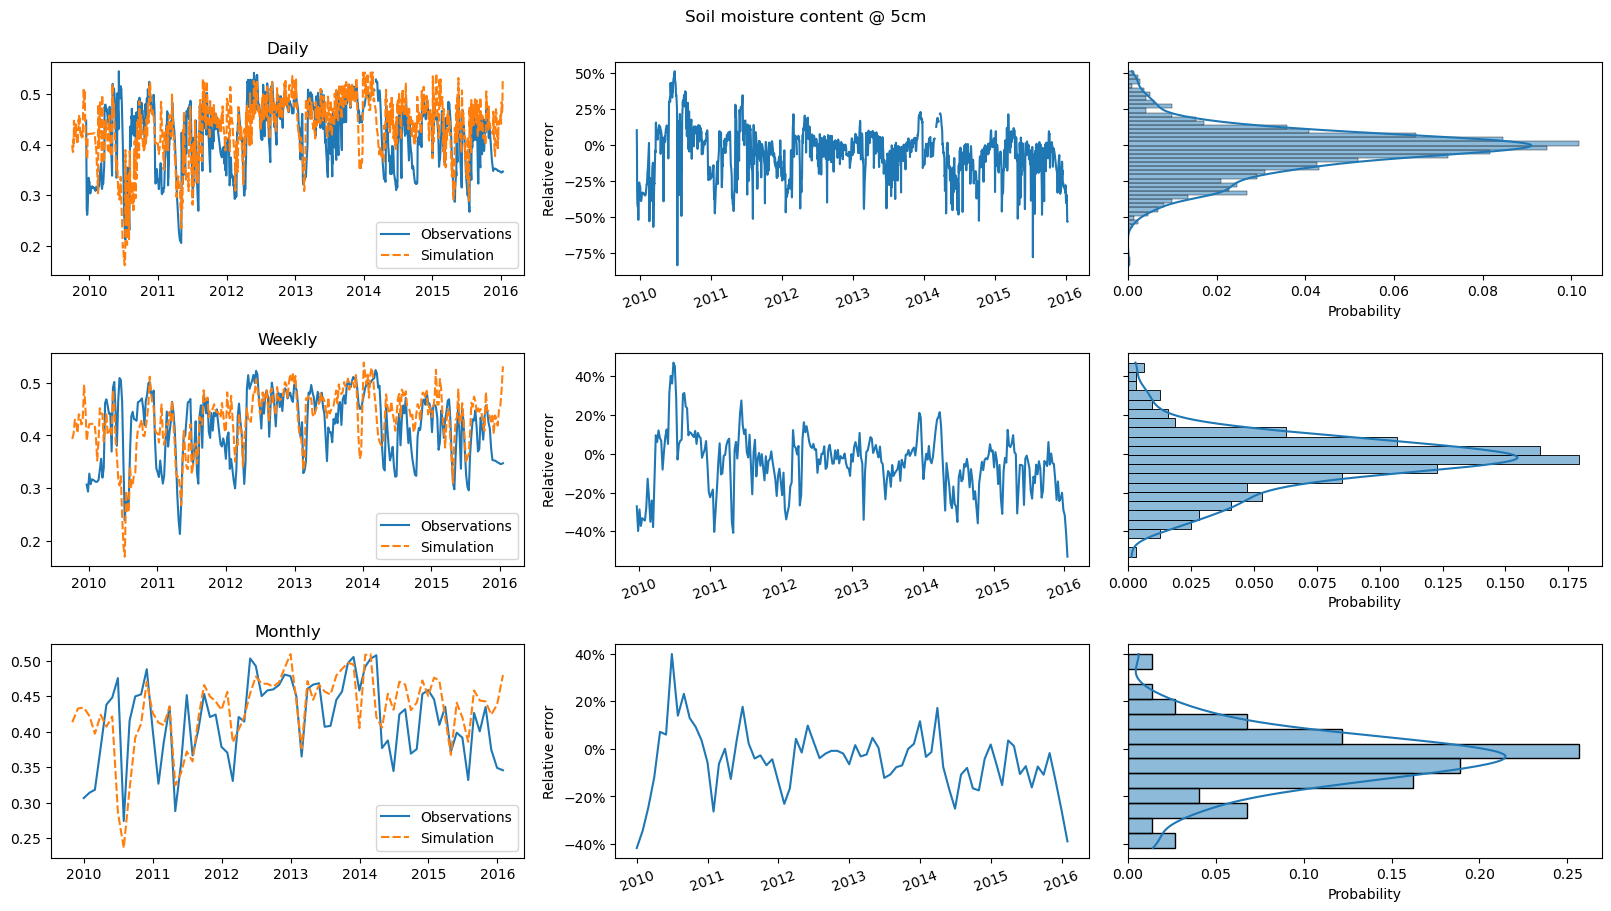

In [8]:
simulation = model(**recommendation)
print(f"After optimization loss is {best_loss}")
comparison_plot(observations,
                simulation,
                desc='Soil moisture content @ 5cm',
                rel=True)
plt.show()

In [10]:
pd.DataFrame.from_dict(recommendation, orient='index', columns=['value'])

,0
NVanGenuchten,1.254999
AlphaVanGenuchten,0.000575
ThetaSat,0.542819
ThetaRes,0.040146
NormalHydrConductivity,0.000728
SoilRoughness,267.444065
LSAI,0.315429
CanopyFraction,0.023877
DecayCoeffCanopy,19.949009
RootDepth,316.808135
